# DINO experiments

In [ ]:
#[using google colab]
#git clone https://github.com/vaopaso/dino.git

Cloning into 'dino'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 168 (delta 10), reused 15 (delta 5), pack-reused 144
Receiving objects: 100% (168/168), 24.47 MiB | 30.55 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
import os
import sys
import argparse

import torch
from torch import nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchvision import transforms as pth_transforms
from torchvision import models as torchvision_models
import numpy as np

sys.path.append("dino")

import utils
import vision_transformer as vits

os.chdir("/content/dino")

In [ ]:
!rm -rf /content/dino/dataset

In [ ]:
# [after manually upload dataset.zip]
!unzip /content/dino/dataset.zip
!rm -rf /content/dino/dataset/.DS_Store
!rm -rf /content/dino/dataset/.ipynb_checkpoints
!ls -lha dataset

Archive:  /content/dino/dataset.zip
   creating: dataset/
   creating: dataset/apple/
   creating: dataset/cat/
   creating: dataset/car/
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/glass/
   creating: dataset/orange/
  inflating: dataset/apple/apples.jpg  
  inflating: __MACOSX/dataset/apple/._apples.jpg  
  inflating: dataset/apple/apple2.jpg  
  inflating: __MACOSX/dataset/apple/._apple2.jpg  
  inflating: dataset/cat/cat1.jpg    
  inflating: __MACOSX/dataset/cat/._cat1.jpg  
  inflating: dataset/cat/cat2.jpg    
  inflating: __MACOSX/dataset/cat/._cat2.jpg  
  inflating: dataset/cat/cat3.jpg    
  inflating: __MACOSX/dataset/cat/._cat3.jpg  
  inflating: dataset/car/car2.jpg    
  inflating: __MACOSX/dataset/car/._car2.jpg  
  inflating: dataset/car/car1.jpg    
  inflating: __MACOSX/dataset/car/._car1.jpg  
  inflating: dataset/glass/glass3.jpg  
  inflating: __MACOSX/dataset/glass/._glass3.jpg  
  inflating: dataset/glas

In [ ]:
@torch.no_grad()
def extract_features(model, data_loader, use_cuda=True, multiscale=False):
    metric_logger = utils.MetricLogger(delimiter="  ")
    features = None
    for samples, index in metric_logger.log_every(data_loader, 10):
        samples = samples.cuda(non_blocking=True)
        index = index.cuda(non_blocking=True)
        if multiscale:
            feats = utils.multi_scale(samples, model)
        else:
            feats = model(samples).clone()

        # init storage feature matrix
        if dist.get_rank() == 0 and features is None:
            features = torch.zeros(len(data_loader.dataset), feats.shape[-1])
            if use_cuda:
                features = features.cuda(non_blocking=True)
            print(f"Storing features into tensor of shape {features.shape}")

        # get indexes from all processes
        y_all = torch.empty(dist.get_world_size(), index.size(0), dtype=index.dtype, device=index.device)
        y_l = list(y_all.unbind(0))
        y_all_reduce = torch.distributed.all_gather(y_l, index, async_op=True)
        y_all_reduce.wait()
        index_all = torch.cat(y_l)

        # share features between processes
        feats_all = torch.empty(
            dist.get_world_size(),
            feats.size(0),
            feats.size(1),
            dtype=feats.dtype,
            device=feats.device,
        )
        output_l = list(feats_all.unbind(0))
        output_all_reduce = torch.distributed.all_gather(output_l, feats, async_op=True)
        output_all_reduce.wait()

        # update storage feature matrix
        if dist.get_rank() == 0:
            if use_cuda:
                features.index_copy_(0, index_all, torch.cat(output_l))
            else:
                features.index_copy_(0, index_all.cpu(), torch.cat(output_l).cpu())
    return features


@torch.no_grad()
def knn_classifier(train_features, train_labels, test_features, test_labels, k, T, num_classes=1000):
    top1, top5, total = 0.0, 0.0, 0
    train_features = train_features.t()
    num_test_images, num_chunks = test_labels.shape[0], 100
    imgs_per_chunk = num_test_images // num_chunks
    retrieval_one_hot = torch.zeros(k, num_classes).to(train_features.device)
    for idx in range(0, num_test_images, imgs_per_chunk):
        # get the features for test images
        features = test_features[
            idx : min((idx + imgs_per_chunk), num_test_images), :
        ]
        targets = test_labels[idx : min((idx + imgs_per_chunk), num_test_images)]
        batch_size = targets.shape[0]

        # calculate the dot product and compute top-k neighbors
        similarity = torch.mm(features, train_features)
        distances, indices = similarity.topk(k, largest=True, sorted=True)
        candidates = train_labels.view(1, -1).expand(batch_size, -1)
        retrieved_neighbors = torch.gather(candidates, 1, indices)

        retrieval_one_hot.resize_(batch_size * k, num_classes).zero_()
        retrieval_one_hot.scatter_(1, retrieved_neighbors.view(-1, 1), 1)
        distances_transform = distances.clone().div_(T).exp_()
        probs = torch.sum(
            torch.mul(
                retrieval_one_hot.view(batch_size, -1, num_classes),
                distances_transform.view(batch_size, -1, 1),
            ),
            1,
        )
        _, predictions = probs.sort(1, True)

        # find the predictions that match the target
        correct = predictions.eq(targets.data.view(-1, 1))
        top1 = top1 + correct.narrow(1, 0, 1).sum().item()
        top5 = top5 + correct.narrow(1, 0, min(5, k)).sum().item()  # top5 does not make sense if k < 5
        total += targets.size(0)
    top1 = top1 * 100.0 / total
    top5 = top5 * 100.0 / total
    return top1, top5


class ReturnIndexDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        img, lab = super(ReturnIndexDataset, self).__getitem__(idx)
        return img, idx


In [ ]:
args = {}
args['batch_size_per_gpu'] = 128
args['nb_knn'] = [10, 20, 100, 200] # Number of NN to use. 20 is usually working the best
args['temperature'] = 0.07  # Temperature used in the voting coefficient
args['pretrained_weights'] = "" # Path to pretrained weights to evaluate 
args['use_cuda'] = True # "Should we store the features on GPU? We recommend setting this to False if you encounter OOM")
args['arch'] = 'vit_small' # 'Architecture'
args['patch_size'] = 8 # 'Patch resolution of the model.')
args['checkpoint_key'] = "teacher" #'Key to use in the checkpoint (example: "teacher")')
args['dump_features'] = None #'Path where to save computed features, empty for no saving')
args['load_features'] = None # """If the features have already been computed, where to find them."""
args['num_workers'] = 10 # 'Number of data loading workers per GPU.')
args["dist_url"] = "env://"# """url used to set up distributed training; see https://pytorch.org/docs/stable/distributed.html"""
args["local_rank"] = 0 # "Please ignore and do not set this argument.")
args['data_path'] = '/content/dino/dataset'

utils.init_distributed_mode(args)
print("git:\n  {}\n".format(utils.get_sha()))
print("\n".join("%s: %s" % (k, str(v)) for k, v in args.items()))
cudnn.benchmark = True

Will run the code on one GPU.


RuntimeError: ignored

In [ ]:
# ============ preparing data ... ============
transform = pth_transforms.Compose([
    pth_transforms.Resize(256, interpolation=3),
    pth_transforms.CenterCrop(224),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
dataset_train = ReturnIndexDataset(args['data_path'], transform=transform)
sampler = torch.utils.data.DistributedSampler(dataset_train, shuffle=False)
data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    sampler=sampler,
    batch_size=args['batch_size_per_gpu'],
    num_workers=args['num_workers'],
    pin_memory=True,
    drop_last=False,
)
print(f"Data loaded with {len(dataset_train)} train imgs.")

# ============ building network ... ============
if "vit" in args['arch']:
    model = vits.__dict__[args['arch']](patch_size=args['patch_size'], num_classes=0)
    print(f"Model {args['arch']} {args['patch_size']}x{args['patch_size']} built.")
elif "xcit" in args['arch']:
    model = torch.hub.load('facebookresearch/xcit:main', args['arch'], num_classes=0)
elif args['arch'] in torchvision_models.__dict__.keys():
    model = torchvision_models.__dict__[args['arch']](num_classes=0)
    model.fc = nn.Identity()
else:
    print(f"Architecture {args['arch']} non supported")
    sys.exit(1)
model.cuda()
utils.load_pretrained_weights(model, args['pretrained_weights'], args['checkpoint_key'], args['arch'], args['patch_size'])
model.eval()

# ============ extract features ... ============
print("Extracting features for train set...")
train_features = extract_features(model, data_loader_train, args['use_cuda'])

if utils.get_rank() == 0:
    train_features = nn.functional.normalize(train_features, dim=1, p=2)

train_labels = torch.tensor([s[-1] for s in dataset_train.samples]).long()
# save features and labels
if args['dump_features'] and dist.get_rank() == 0:
    torch.save(train_features.cpu(), os.path.join(args['dump_features'], "trainfeat.pth"))
    torch.save(train_labels.cpu(), os.path.join(args['dump_features'], "trainlabels.pth"))

print()
print('Train features shape:', train_features.shape)
print('Train labels shape:', train_labels.shape)
print('Total classes:', torch.max(train_labels).item() + 1)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Data loaded with 18 train imgs.
Model vit_small 8x8 built.
Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_pretrain.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

Extracting features for train set...
Storing features into tensor of shape torch.Size([18, 384])
  [0/1]  eta: 0:00:00    time: 0.546314  data: 0.463342  max mem: 705
 Total time: 0:00:00 (0.724437 s / it)

Train features shape: torch.Size([18, 384])
Train labels shape: torch.Size([18])
Total classes: 5


In [ ]:
dataset_train.samples

[('/content/dino/dataset/apple/apple2.jpg', 0),
 ('/content/dino/dataset/apple/apples.jpg', 0),
 ('/content/dino/dataset/car/car1.jpg', 1),
 ('/content/dino/dataset/car/car2.jpg', 1),
 ('/content/dino/dataset/cat/cat1.jpg', 2),
 ('/content/dino/dataset/cat/cat2.jpg', 2),
 ('/content/dino/dataset/cat/cat3.jpg', 2),
 ('/content/dino/dataset/glass/glass1.jpg', 3),
 ('/content/dino/dataset/glass/glass2.jpg', 3),
 ('/content/dino/dataset/glass/glass3.jpg', 3),
 ('/content/dino/dataset/glass/glass_test.jpg', 3),
 ('/content/dino/dataset/glass/glass_test2.jpg', 3),
 ('/content/dino/dataset/glass/glass_test3.jpg', 3),
 ('/content/dino/dataset/glass/glass_test4.jpg', 3),
 ('/content/dino/dataset/glass/glass_test5.jpg', 3),
 ('/content/dino/dataset/glass/glass_test6.jpg', 3),
 ('/content/dino/dataset/orange/orange2.jpg', 4),
 ('/content/dino/dataset/orange/oranges.jpg', 4)]

## Euclidian distance between each pair of samples

In [ ]:
features = [train_features[i].cpu().numpy() for i in range(train_features.shape[0])]

In [ ]:
for i in range(train_features.shape[0]):
  i_str = os.path.splitext(os.path.basename(dataset_train.samples[i][0]))[0]
  L = []
  for j in range(train_features.shape[0]):
    if i != j:
      j_str = os.path.splitext(os.path.basename(dataset_train.samples[j][0]))[0]
      dist = np.linalg.norm(features[i]-features[j])
      #print(f'{i_str} - {j_str}:', dist)
      L.append((j_str, dist))
  L.sort(key = lambda x: x[1])
  for (j_str, dist) in L:
    print(f'{i_str} - {j_str}:', dist)
  print()

apple2 - oranges: 0.7050037
apple2 - apples: 1.1446371
apple2 - orange2: 1.1639165
apple2 - glass_test6: 1.3546542
apple2 - glass_test: 1.3621867
apple2 - cat2: 1.3659412
apple2 - glass_test2: 1.371189
apple2 - car2: 1.379837
apple2 - cat3: 1.3809657
apple2 - cat1: 1.3861332
apple2 - glass_test4: 1.389258
apple2 - glass_test3: 1.3909973
apple2 - glass2: 1.4064888
apple2 - glass3: 1.4132663
apple2 - glass1: 1.4195579
apple2 - car1: 1.4419392
apple2 - glass_test5: 1.4627247

apples - apple2: 1.1446371
apples - orange2: 1.14991
apples - oranges: 1.2009071
apples - cat2: 1.2942468
apples - cat3: 1.3294716
apples - cat1: 1.3468006
apples - glass3: 1.3502388
apples - car2: 1.3789583
apples - glass_test: 1.3847811
apples - glass1: 1.38574
apples - glass2: 1.387687
apples - glass_test3: 1.397899
apples - glass_test6: 1.3987292
apples - glass_test2: 1.4018514
apples - glass_test5: 1.408942
apples - glass_test4: 1.4145314
apples - car1: 1.4192659

car1 - car2: 0.8286885
car1 - glass_test: 1.3272

## visualize t-SNE embeddings

In [ ]:
labels = train_labels.cpu().numpy()
cls_names = {}
for sample in dataset_train.samples:
  cls = sample[1]
  if cls not in cls_names:
     cls_names[cls] = os.path.basename(os.path.dirname(sample[0]))

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X = np.array(features)
#pca = PCA(n_components=9)
#X = pca.fit_transform(X)
X_embedded = TSNE(n_components=2, perplexity=3, learning_rate='auto', init='random').fit_transform(X)

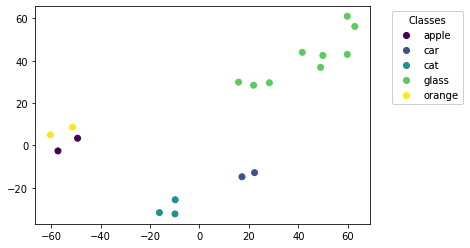

In [ ]:
import matplotlib.pyplot as plt

#colors_dict = {'cat': 'blue', 'car': 'red', 'apple': 'magenta', 'orange': 'orange', 'glass': 'green'}
#colors = np.array([colors_dict[cls_names[x]] for x in labels])
# names = np.array([cls_names[x] for x in labels])
# plot
fig, ax = plt.subplots()
scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=labels)

total_classes = torch.max(train_labels).item() + 1
b = [0, '$\\mathdefault{1}$', '$\\mathdefault{2}$', '$\\mathdefault{3}$']
names = [cls_names[i] for i in range(total_classes)]

legend1 = ax.legend(scatter.legend_elements()[0], names, loc="upper left", title="Classes", bbox_to_anchor = (1.05, 1))
ax.add_artist(legend1)

plt.show()


[1 1 3 3 2 2 2 0 0 0 4 0 0 4 0 4 1 1] [[ 53.81995031  47.22091972]
 [-54.51156425   3.60994029]
 [-11.96303527 -29.86378288]
 [ 19.75001621 -13.79963493]
 [ 22.0016123   29.29784431]] [[[56.75866244 41.03312718]
  [41.03312718 71.32311765]]

 [[19.57819947  5.99286751]
  [ 5.99286751 16.33313201]]

 [[ 8.95673269  3.94264828]
  [ 3.94264828  9.08422606]]

 [[ 6.46225377  2.47958959]
  [ 2.47958959  0.95142843]]

 [[25.89233543 -0.53684831]
  [-0.53684831  0.40290894]]]


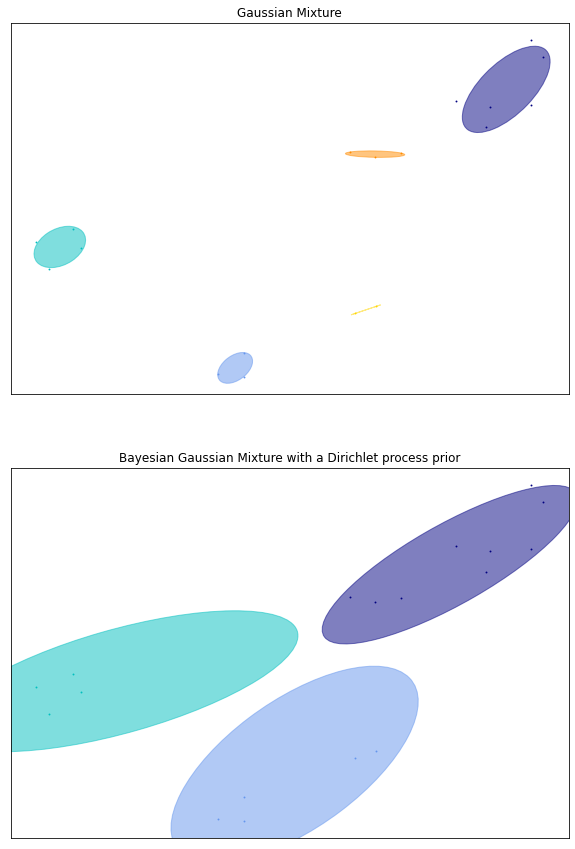

In [ ]:
import itertools
import numpy as np
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from scipy import linalg
import matplotlib as mpl

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

plt.figure(figsize=(10, 15))
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.ylim(-3.0, 6.0)
    #plt.xlim(-9.0, 5.0)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

# Fit a Gaussian mixture with EM using five components
gmm = GaussianMixture(n_components=5, covariance_type="full").fit(X_embedded)
print(gmm.predict(X_embedded), gmm.means_, gmm.covariances_)
plot_results(X_embedded, gmm.predict(X_embedded), gmm.means_, gmm.covariances_, 0, "Gaussian Mixture")

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = BayesianGaussianMixture(n_components=5, covariance_type="full").fit(X_embedded)
plot_results(
    X_embedded,
    dpgmm.predict(X_embedded),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    "Bayesian Gaussian Mixture with a Dirichlet process prior",
)

plt.show()

## Learn representations

In [ ]:
import pickle

with open('features.pkl', 'wb') as f:
  pickle.dump(X, f)

In [ ]:
with open('features.pkl', 'rb') as f:
  X = pickle.load(f)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
print('features shape:', X.shape)
print('original labels:', labels)
real_labels = [None] * labels.shape[0] # we assume the model does not know any labels yet
print('real labels: ', real_labels)

features shape: (18, 384)
original labels: [0 0 1 1 2 2 2 3 3 3 3 3 3 3 3 3 4 4]
real labels:  [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [ ]:
import statistics

def knn(x, K=3):
  dists = []
  for i in range(X.shape[0]):
    x2 = X[i,:]
    dist = np.linalg.norm(x-x2)
    if dist > 0:
      label = real_labels[i]
      img_name = os.path.splitext(os.path.basename(dataset_train.samples[i][0]))[0]
      #label_name = os.path.basename(os.path.dirname(dataset_train.samples[i][0]))
      dists.append((dist, label, img_name))
    else:
      img_name = os.path.splitext(os.path.basename(dataset_train.samples[i][0]))[0]
      print(f'img_name: {img_name}')
      print()
  dists.sort(key = lambda x: x[0])
  dists = dists[:K]
  dists_labels = [x[1] for x in dists]
  mode = statistics.mode(dists_labels)
  
  if mode is None:
    if all([x is None for x in dists_labels]):
      return mode, dists[:K]  # later will need to assign label of x input img
    # else
    mode = statistics.mode([x for x in dists_labels if x is not None])
    return mode, dists[:K]

  return mode, dists[:K]

pred_cls, neighbrs = knn(X[10,:])
print(f'predicted class: {pred_cls}')
print(f'neighbors scores: {neighbrs}')

img_name: glass_test

predicted class: None
neighbors scores: [(0.7116389, None, 'glass_test6'), (0.90506357, None, 'glass_test2'), (0.92434984, None, 'glass_test3')]


## Attention maps visualization

In [ ]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

import utils
import vision_transformer as vits


def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


attn_output/attn-head0.png saved.
attn_output/attn-head1.png saved.
attn_output/attn-head2.png saved.
attn_output/attn-head3.png saved.
attn_output/attn-head4.png saved.
attn_output/attn-head5.png saved.
attn_output/mask_th0.8_head0.png saved.
attn_output/mask_th0.8_head1.png saved.
attn_output/mask_th0.8_head2.png saved.
attn_output/mask_th0.8_head3.png saved.
attn_output/mask_th0.8_head4.png saved.
attn_output/mask_th0.8_head5.png saved.


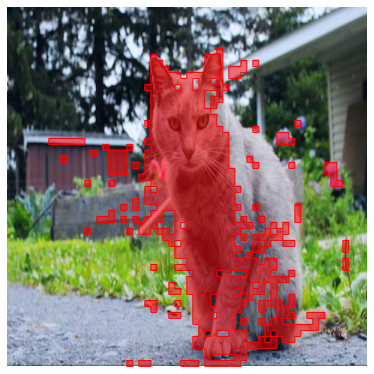

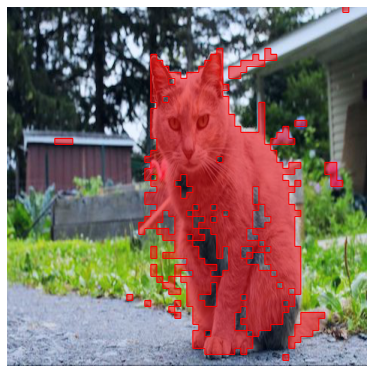

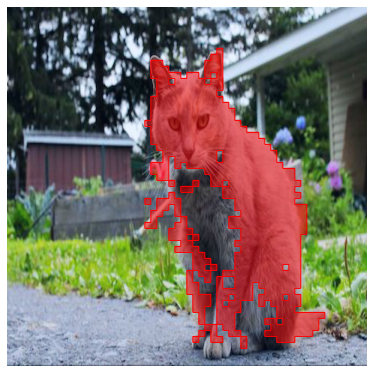

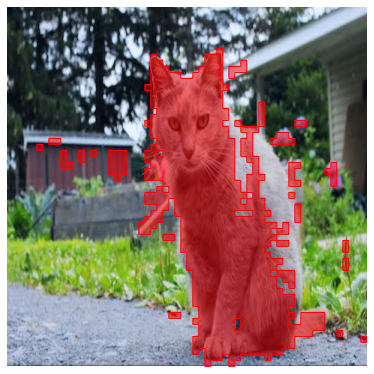

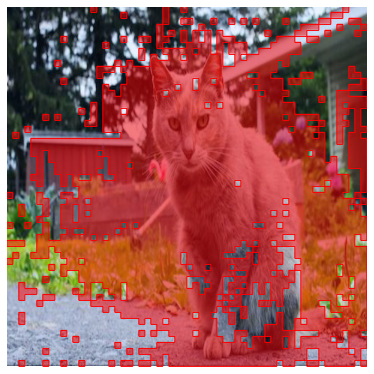

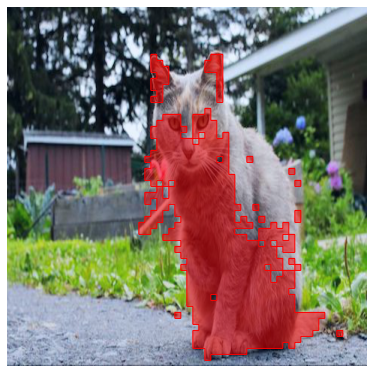

In [ ]:
args = {}
args['arch'] = 'vit_small' # ['vit_tiny', 'vit_small', 'vit_base'] Architecture (support only ViT atm)
args['patch_size'] = 8 # Patch resolution of the model.
args['pretrained_weights'] = '' # Path to pretrained weights to load.
args["checkpoint_key"] = "teacher" # Key to use in the checkpoint (example: "teacher")
args["image_path"] = '/content/dino/dataset/cat/cat1.jpg' # Path of the image to load.
args["image_size"] = (480, 480) # Resize image.
args['output_dir'] = 'attn_output' # Path where to save visualizations.
args["threshold"] = 0.8 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# build model
model = vits.__dict__[args['arch']](patch_size=args['patch_size'], num_classes=0)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)
if os.path.isfile(args['pretrained_weights']):
    state_dict = torch.load(args['pretrained_weights'], map_location="cpu")
    if args['checkpoint_key'] is not None and args['checkpoint_key'] in state_dict:
        print(f"Take key {args['checkpoint_key']} in provided checkpoint dict")
        state_dict = state_dict[args['checkpoint_key']]
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
    print('Pretrained weights found at {} and loaded with msg: {}'.format(args['pretrained_weights'], msg))
else:
    print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
    url = None
    if args['arch'] == "vit_small" and args['patch_size'] == 16:
        url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
    elif args['arch'] == "vit_small" and args['patch_size'] == 8:
        url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"  # model used for visualizations in our paper
    elif args['arch'] == "vit_base" and args['patch_size'] == 16:
        url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
    elif args['arch'] == "vit_base" and args['patch_size'] == 8:
        url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
    if url is not None:
        print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
        state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
        model.load_state_dict(state_dict, strict=True)
    else:
        print("There is no reference weights available for this model => We use random weights.")

# open image
if args['image_path'] is None:
    # user has not specified any image - we use our own image
    print("Please use the `--image_path` argument to indicate the path of the image you wish to visualize.")
    print("Since no image path have been provided, we take the first image in our paper.")
    response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB')
elif os.path.isfile(args['image_path']):
    with open(args['image_path'], 'rb') as f:
        img = Image.open(f)
        img = img.convert('RGB')
else:
    print(f"Provided image path {args['image_path']} is non valid.")
    sys.exit(1)
transform = pth_transforms.Compose([
    pth_transforms.Resize(args['image_size']),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % args['patch_size'], img.shape[2] - img.shape[2] % args['patch_size']
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // args['patch_size']
h_featmap = img.shape[-1] // args['patch_size']

attentions = model.get_last_selfattention(img.to(device))

nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

if args['threshold'] is not None:
    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - args['threshold'])
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=args['patch_size'], mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=args['patch_size'], mode="nearest")[0].cpu().numpy()

# save attentions heatmaps
os.makedirs(args['output_dir'], exist_ok=True)
torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(args['output_dir'], "img.png"))
for j in range(nh):
    fname = os.path.join(args['output_dir'], "attn-head" + str(j) + ".png")
    plt.imsave(fname=fname, arr=attentions[j], format='png')
    print(f"{fname} saved.")

if args['threshold'] is not None:
    image = skimage.io.imread(os.path.join(args['output_dir'], "img.png"))
    for j in range(nh):
        display_instances(image, th_attn[j], fname=os.path.join(args['output_dir'], "mask_th" + str(args['threshold']) + "_head" + str(j) +".png"), blur=False)


In [ ]:
!zip -r attn_output.zip /content/dino/attn_output

updating: content/dino/attn_output/ (stored 0%)
updating: content/dino/attn_output/attn-head3.png (deflated 21%)
updating: content/dino/attn_output/attn-head1.png (deflated 20%)
updating: content/dino/attn_output/img.png (deflated 0%)
updating: content/dino/attn_output/attn-head5.png (deflated 24%)
updating: content/dino/attn_output/attn-head0.png (deflated 25%)
updating: content/dino/attn_output/attn-head2.png (deflated 20%)
updating: content/dino/attn_output/attn-head4.png (deflated 17%)
  adding: content/dino/attn_output/mask_th0.8_head0.png (deflated 0%)
  adding: content/dino/attn_output/mask_th0.8_head3.png (deflated 0%)
  adding: content/dino/attn_output/mask_th0.8_head1.png (deflated 0%)
  adding: content/dino/attn_output/mask_th0.8_head5.png (deflated 0%)
  adding: content/dino/attn_output/mask_th0.8_head2.png (deflated 0%)
  adding: content/dino/attn_output/mask_th0.8_head4.png (deflated 0%)


### Convert video to attention map video

In [ ]:
!wget https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth

--2021-12-05 15:39:29--  https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86728949 (83M) [application/zip]
Saving to: ‘dino_deitsmall8_pretrain.pth’

dino_deitsmall8_pre 100%[===================>]  82.71M  25.0MB/s    in 3.3s    

2021-12-05 15:39:32 (25.0 MB/s) - ‘dino_deitsmall8_pretrain.pth’ saved [86728949/86728949]



In [ ]:
!python video_generation.py  --pretrained_weights /content/dino/dino_deitsmall8_pretrain.pth \
    --input_path /content/dino/video2.mp4 \
    --output_path output/ \
    --fps 25

Pretrained weights found at /content/dino/dino_deitsmall8_pretrain.pth and loaded with msg: <All keys matched successfully>
Video: /content/dino/video2.mp4 (23.522964249364772 fps)
Extracting frames to output/frames
Generating attention images to output/attention
  0% 0/661 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recomp

In [ ]:
!rm -rf /content/dino/output
!mkdir /content/dino/output

In [ ]:
torch.cuda.empty_cache()